# Signal Processing Tutorial #1 - Preprocessing

Preprocessing is the process of performing initial signal clean-up before extracting information from the signal. 

Preprocessing includes, but not limit to, the follwing procedures:

1. Data Organization and Signal Conditioning
2. Signal Filtering
3. Artifact Removals

In [42]:
# First adding a bunch of modules that we will use. Check python-scripts repository
import os, sys
sys.path.append("../../python-scripts/")

import numpy as np
from utility import SignalProcessingUtility as SPU
from utility import GraphingUtility as GU

## Data Organization

Data often comes to the user via different formats. Especially if data comes from a variety of different recording systems or companies. Usually, data organization is a very subjective topic because different people have different preference on how they handle their data, and every method is reasonable and realiable as long as you keep the same standard throughout your analysis. 

This is especially important if you develop a certain pipeline for data analysis, and you want the pipeline to work for different projects and data. Data organization is key to ensure that different data fit within the same structure or naming schemes for your pipeline so you do not have to rewrite codes for different projects that require similar analysis.

In here I will describe one way of doing it, which is through a single dictionary.

In [3]:
# Given a random signal
signal = np.random.rand(10000)

# If you know the sampling rate (100Hz as example)
sampling_rate = 100

# Now you can create a dictionary hosting your data
Recording = {
  "Data": signal,
  "Time": np.arange(len(signal)) / sampling_rate,
  "FS": sampling_rate
}
print(Recording)

# now you can access your recording data via 
print(Recording["Data"])

{'Data': array([0.37592025, 0.05714402, 0.33097029, ..., 0.27838067, 0.16467082,
       0.93231673]), 'Time': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01]), 'FS': 100}
[0.37592025 0.05714402 0.33097029 ... 0.27838067 0.16467082 0.93231673]


### Data Cacheing

Some time you may want to save your organized data in local file so you can load the file directly or share that with others. Python utilize different method for file storage, one of the most common way is through **pickle** module. 

This is a simple way of saving binary data without compression or encryption. This is simply writing raw binary data to file and reading it back when needed. 

In [4]:
import pickle as pkl

# Saving data
TargetFilename = "Recording.pkl"
with open(TargetFilename, "wb+") as file:
  pkl.dump(Recording, file)

# Reading saved data
with open(TargetFilename, "wb+") as file:
  Recording = pkl.load(file)

Alternatively, some people may choose to use MATLAB's mat file format for storage. This works in certain scenario but not all scenario due to compatibility between MATLAB data type and Python data type. 

To use MATLAB's file format, you will need **scipy** module.

In [31]:
from scipy import io as sio

TargetFilename = "Recording.mat"

# DataToSave MUST BE a dictionary. The key is variable name and value is the actual data.
DataToSave = {
  "Recording": Recording,
  "MoreData": "test"
}
sio.savemat(TargetFilename, DataToSave)

# As you can see, the loading is a lot more complicated with default parameters failed to load the mat file we just saved.
DataRead = sio.loadmat(TargetFilename, struct_as_record=False, squeeze_me=True)
print(DataRead)
print(DataRead["Recording"].Data)

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Aug  5 15:10:28 2022', '__version__': '1.0', '__globals__': [], 'Recording': <scipy.io.matlab.mio5_params.mat_struct object at 0x7f64ad870f10>, 'MoreData': 'test'}
[0.37592025 0.05714402 0.33097029 ... 0.27838067 0.16467082 0.93231673]


## Signal Filtering

Filter in Python is usually done through **scipy** module. There are many filter options available in **scipy.signal** class. You can see all of them [here](https://docs.scipy.org/doc/scipy/reference/signal.html). We will talk about the most basic IIR filter and FIR filter only. 

FIR (Finite Impulse Response) filter is a stable filter in which the filter is only applying to the incoming signals. IIR (Infinite Impulse Response) filter is a potentially unstable filter because the filter is applying to both the incoming signals and the previous output of the filter. If a bad datapoint lead to Inf/-Inf response in IIR filter, that data point will have a never-ending effect on the rest of the datapoint; however, in FIR filter, output may be destructive for the duration of the filter length, but afterward the signal will be stable again because the bad datapoint is in the past and is no longer being considered in sequential filtering of the signal. 

IIR filter is good in a way that you only need very short filter-order to achieve sharp filter cutoff. However, FIR filter may not be as effective unless a significantly long filter window is used, which may lead to significant phase delay. 

The most common IIR filter is butterworth filter.

In [69]:
# Random Data as Example
import pickle as pkl
with open("../example/RandomRecording.pkl", "rb") as file:
  Recording = pkl.load(file)

from scipy import signal
# 5th-order Butterworth Lowpass filter for below 100Hz
[b,a] = signal.butter(5, 100*2/Recording["FS"], btype="lowpass")
Recording["ButterData"] = signal.filtfilt(b, a, Recording["Data"])

# 5th-order Butterworth Highpass filter for trend removal
[b,a] = signal.butter(5, 0.05*2/Recording["FS"], btype="highpass")
Recording["ButterData"] = signal.filtfilt(b, a, Recording["ButterData"])

# 5th-order Butterworth Bandpass Filter between 5 to 80Hz
[b,a] = signal.butter(5, np.array([5,80])*2/Recording["FS"], btype="bandpass")
Recording["ButterData"] = signal.filtfilt(b, a, Recording["ButterData"])

# 5th-order Butterworth Bandstop Filter between 55 to 65Hz (Notch Filter for North America)
[b,a] = signal.butter(5, np.array([55,65])*2/Recording["FS"], btype="bandstop")
Recording["ButterData"] = signal.filtfilt(b, a, Recording["ButterData"])


# Now repeat with FIR filter
b = signal.firwin(49, 100*2/Recording["FS"], pass_zero="lowpass")
Recording["FIRData"] = signal.filtfilt(b, 1, Recording["Data"])

b = signal.firwin(49, 0.05*2/Recording["FS"], pass_zero="highpass")
Recording["FIRData"] = signal.filtfilt(b, 1, Recording["FIRData"])

b = signal.firwin(49, np.array([5,80])*2/Recording["FS"], pass_zero="bandpass")
Recording["FIRData"] = signal.filtfilt(b, 1, Recording["FIRData"])

b = signal.firwin(49, np.array([55,65])*2/Recording["FS"], pass_zero="bandstop")
Recording["FIRData"] = signal.filtfilt(b, 1, Recording["FIRData"])

# Now repeat with FIR filter longer
b = signal.firwin(249, 100*2/Recording["FS"], pass_zero="lowpass")
Recording["FIRData2"] = signal.filtfilt(b, 1, Recording["Data"])

b = signal.firwin(249, 0.05*2/Recording["FS"], pass_zero="highpass")
Recording["FIRData2"] = signal.filtfilt(b, 1, Recording["FIRData2"])

b = signal.firwin(249, np.array([5,80])*2/Recording["FS"], pass_zero="bandpass")
Recording["FIRData2"] = signal.filtfilt(b, 1, Recording["FIRData2"])

b = signal.firwin(249, np.array([55,65])*2/Recording["FS"], pass_zero="bandstop")
Recording["FIRData2"] = signal.filtfilt(b, 1, Recording["FIRData2"])

You can visualize the result via simple Fourier Transform, using Welch's Periodogram

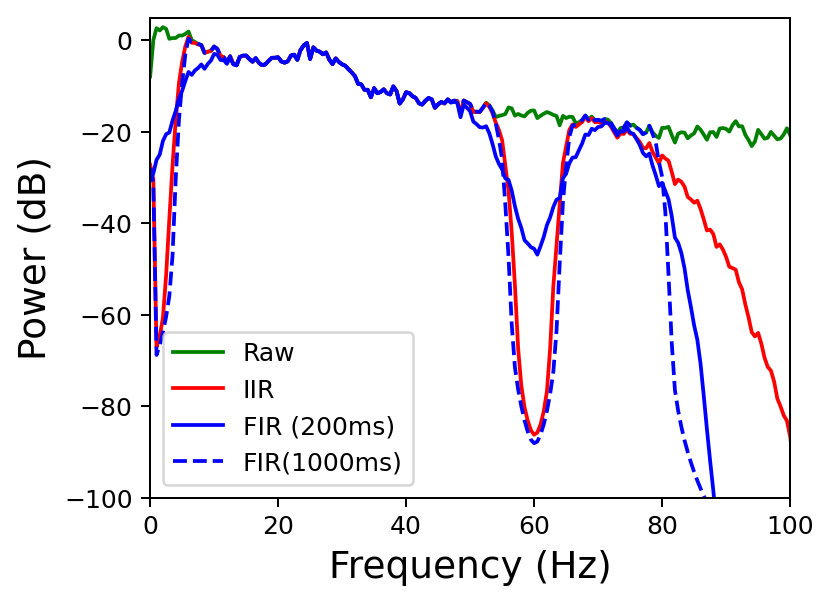

In [71]:
fig = GU.largeFigure(0, [800,600], dpi=180)
ax = GU.addAxes(fig)

[Frequency, Power] = signal.welch(Recording["Data"], nperseg=Recording["FS"]*2, noverlap=Recording["FS"]*1, fs=Recording["FS"])
ax.plot(Frequency, 10*np.log10(Power), "g")

[Frequency, Power] = signal.welch(Recording["ButterData"], nperseg=Recording["FS"]*2, noverlap=Recording["FS"]*1, fs=Recording["FS"])
ax.plot(Frequency, 10*np.log10(Power), "r")

[Frequency, Power] = signal.welch(Recording["FIRData"], nperseg=Recording["FS"]*2, noverlap=Recording["FS"]*1, fs=Recording["FS"])
ax.plot(Frequency, 10*np.log10(Power), "b-")

[Frequency, Power] = signal.welch(Recording["FIRData2"], nperseg=Recording["FS"]*2, noverlap=Recording["FS"]*1, fs=Recording["FS"])
ax.plot(Frequency, 10*np.log10(Power), "b--")

ax.set_xlim(0, 100)
ax.set_ylim(-100,5)
ax.set_xlabel("Frequency (Hz)", fontsize=15)
ax.set_ylabel("Power (dB)", fontsize=15)
ax.legend(ax.get_lines(), ["Raw", "IIR", "FIR (200ms)", "FIR(1000ms)"])